# Melk: What happens here?
Based on pymc-marketing example notebook (02_mmm_example.ipynb)

## Changes
- Make adstock and saturation almost vanish in simulated data (but keep code for later)
- Remove dayofweek
- Add confounder x1 (FB) to x2 (Google)
- Do own model for that by hand

In [11]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.delayed_saturated_mmm import MMM
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

from utils03 import MelkConfounder

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
LOAD_FROM_DISK = False
# set filename to current filename
model_name = "03_mmm_example.savedmodel"

## Generate Data

### 1. Date Range

First we set a time range for our data. We consider a bit more than 2 years of data at weekly granularity.

In [13]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2024-01-01")
max_date = pd.to_datetime("2024-05-30")

df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="D")}
).assign(
    year=lambda x: x["date"].dt.year,
    month=lambda x: x["date"].dt.month,
    dayofyear=lambda x: x["date"].dt.dayofyear,
    dayofweek=lambda x: x["date"].dt.dayofweek, # Monday=0, Sunday=6
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 151


In [14]:
true_values = {
    "beta_y0": 0.5,
    # "beta_fb_0": 2.0, # defined post simulated data
    "beta_fb_y": 0.5,
    "beta_fb_sem": 0.3,
    "beta_sem_0": 0.3, # defined post simulated data
    "beta_sem_y": 0.6,
    "sigma_y" : 0.1,
}

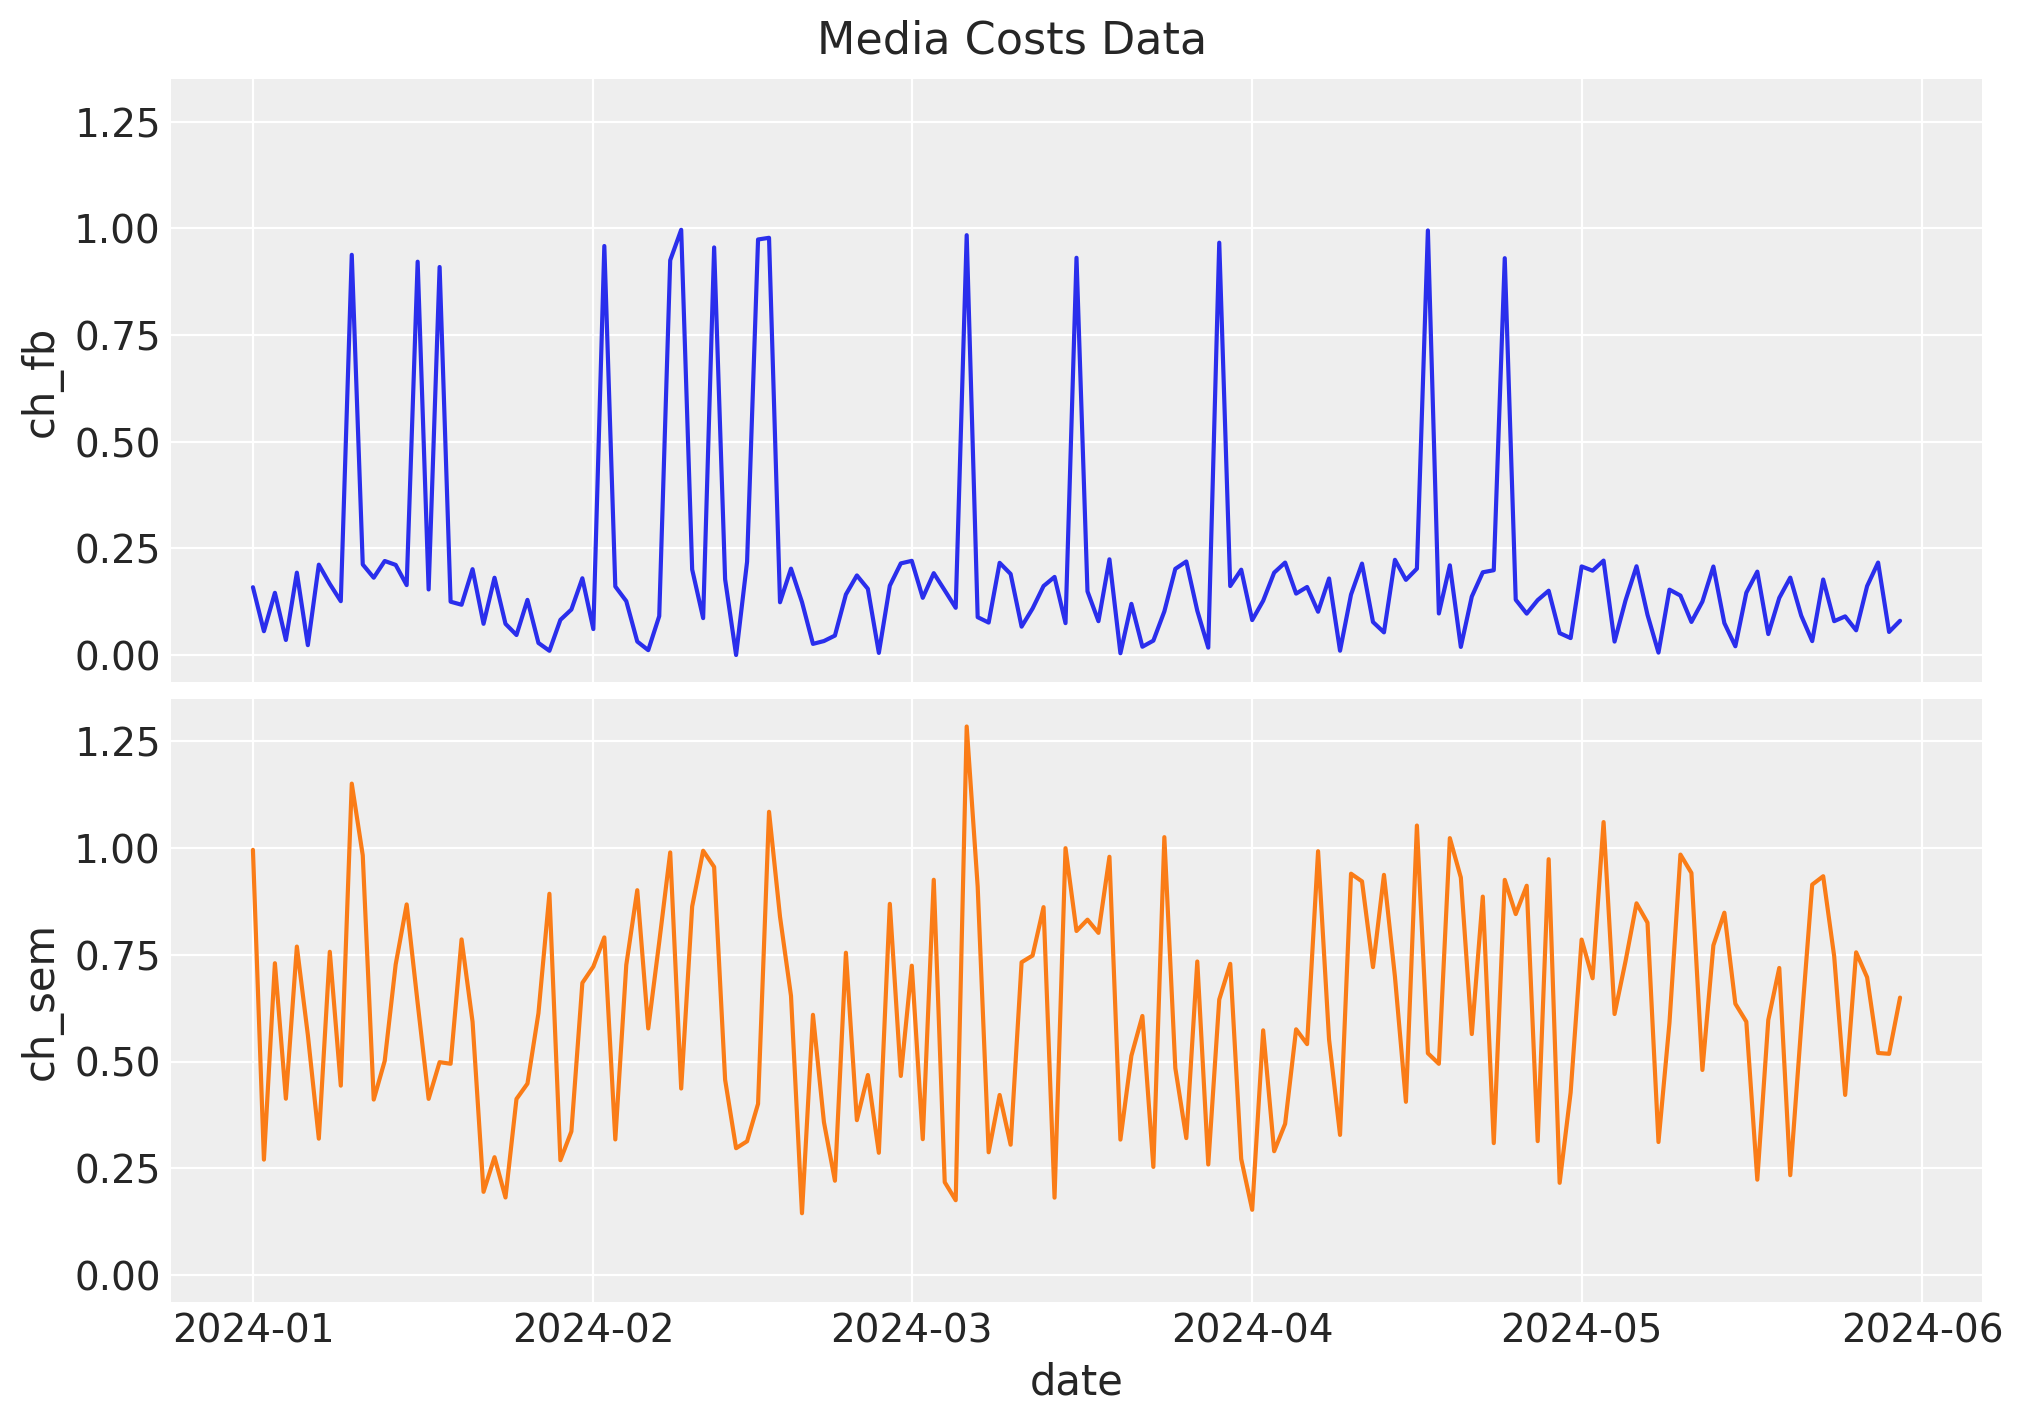

In [15]:
# media spend data  Facebook
ch_fb_rnd = rng.uniform(low=0.0, high=1.0, size=n)
df["ch_fb"] = np.where(ch_fb_rnd > 0.9, ch_fb_rnd, ch_fb_rnd / 4)

# media spend for X2 - Google. Gets a confounding boost from X1.
sem_0_rnd = rng.uniform(low=0.1, high=1.0, size=n)
sem_own = sem_0_rnd 
sem_from_fb = df["ch_fb"] * true_values["beta_fb_sem"]
df["ch_sem"] = sem_own + sem_from_fb

# infer "true values" for the last parameters to compare with the posterior predictive distributions
true_values["beta_fb_0"] = df["ch_fb"].mean() 
true_values["beta_sem_0"] = sem_own.mean()

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date", y="ch_fb", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date", y="ch_sem", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

We can now visualize the effect signal for each channel after each transformation:

### 3.1 Weekday Components

In [16]:
# Extra sales on Mon to Sat - Sun is the base and goes into intercept
dow_gamma_true = [1.0, 0.3, 0.3, 0.5, 0.3, 0.3]

def add_dayofweek(df: pd.DataFrame) -> pd.DataFrame:
    df["dayofweek"] = df.assign(dayofweek=lambda x: x["date"].dt.dayofweek)["dayofweek"]
    for dayofweek in range(6):
        df[f"dayofweek_{dayofweek}"] = np.where(df["dayofweek"] == dayofweek, 1, 0)
    return df

# add columns for day of week
df = add_dayofweek(df)

# define list of dayofweek variables for later use
control_dayofweek = [f"dayofweek_{dayofweek}" for dayofweek in range(6)]

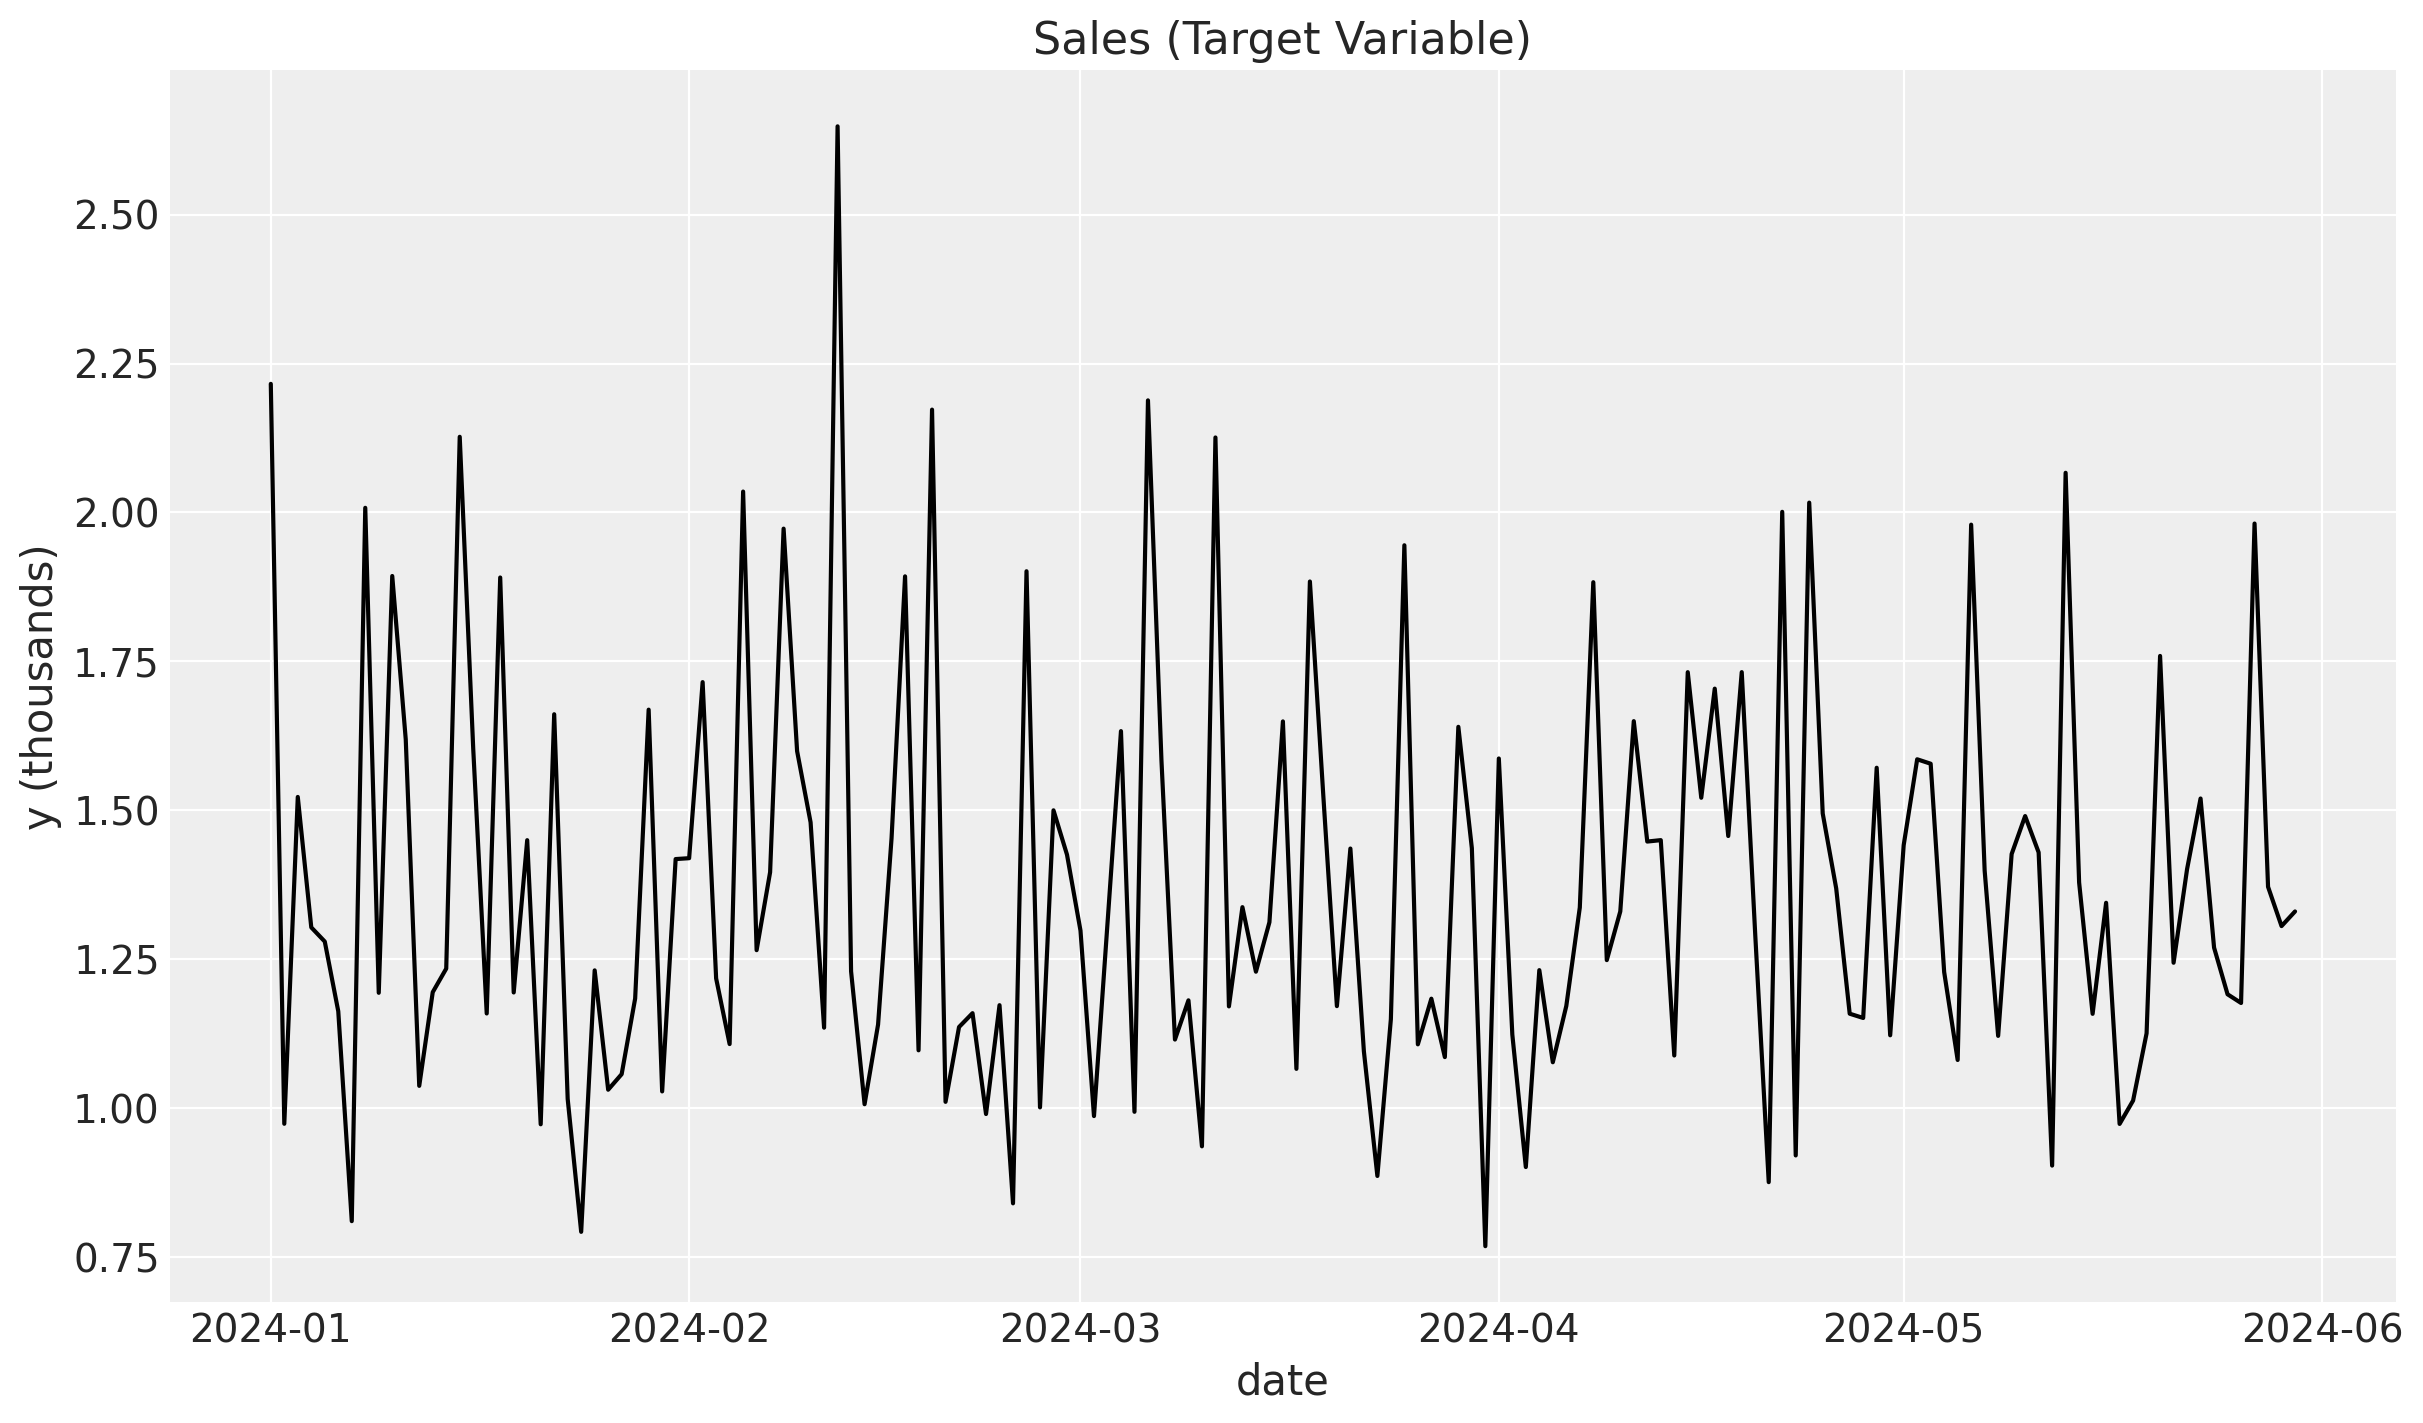

In [17]:
df["intercept"] = true_values["beta_y0"]
df["epsilon"] = rng.normal(loc=0.0, scale=true_values["sigma_y"], size=n)

df["y"] = (
    df["intercept"] + 
    df["ch_fb"] * true_values["beta_fb_y"] +
    df["ch_sem"] * true_values["beta_sem_y"] 
    + df["epsilon"] 
) 
# add day of week effect
df["dayofweek_effect"] = df["y"] * 0
for dayofweek in range(6):
    effect = df[f"dayofweek_{dayofweek}"] * dow_gamma_true[dayofweek] 
    df["dayofweek_effect"] = df["dayofweek_effect"] + effect

df["y"] = df["y"] + df["dayofweek_effect"] 
# df

fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

<Axes: >

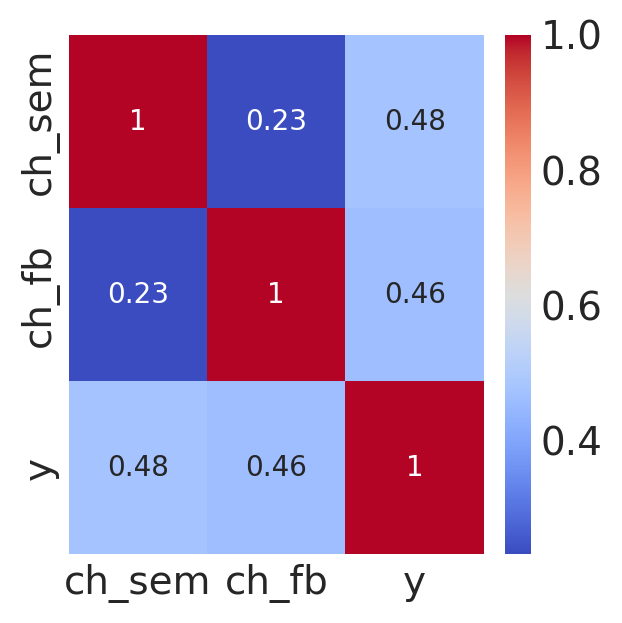

In [18]:
# correlation of media spend with sales
corr = df[["ch_sem", "ch_fb", "y"]].corr()
fig, ax = plt.subplots()
fig.set_size_inches(3, 3)
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)

### 7. Data Output

We of course will not have all of these features in our real data. Let's filter out the features we will use for modeling:

In [19]:
columns_to_keep = [
    "date",
    "y",
    "ch_fb",
    "ch_sem",
    # "event_1",
    # "event_2",
    # "dayofyear",
] # + control_dayofweek 

data = df[columns_to_keep].copy()

data

,date,y,ch_fb,ch_sem
0,2024-01-01,2.215843,0.159290,0.995877
1,2024-01-02,0.973762,0.056194,0.270224
2,2024-01-03,1.522410,0.146200,0.730335
3,2024-01-04,1.303424,0.035699,0.412954
4,2024-01-05,1.279666,0.193373,0.769331
...,...,...,...,...
146,2024-05-26,1.176546,0.058374,0.755870
147,2024-05-27,1.981369,0.161890,0.697337
148,2024-05-28,1.371595,0.217061,0.520046
149,2024-05-29,1.305638,0.054494,0.518085


## Part II: Modeling

On this second part, we focus on the modeling process. We will use the data generated in Part I.

## 2. Model Specification

Next, we specify the `sigma` parameter per channel: 

## 3. Model Fitting

Create the mmm model:

In [20]:
mmm = MelkConfounder(data, true_values, datevarname="date")

Fit the model and show the graph

In [22]:
mmm.define_model()  
mmm.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_fb_0, beta_fb_y, beta_fb_sem, beta_sem_0, beta_sem_y, sigma_y, gamma_dayofweek]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
Sampling: [ch_fb, ch_sem, y]


Output()

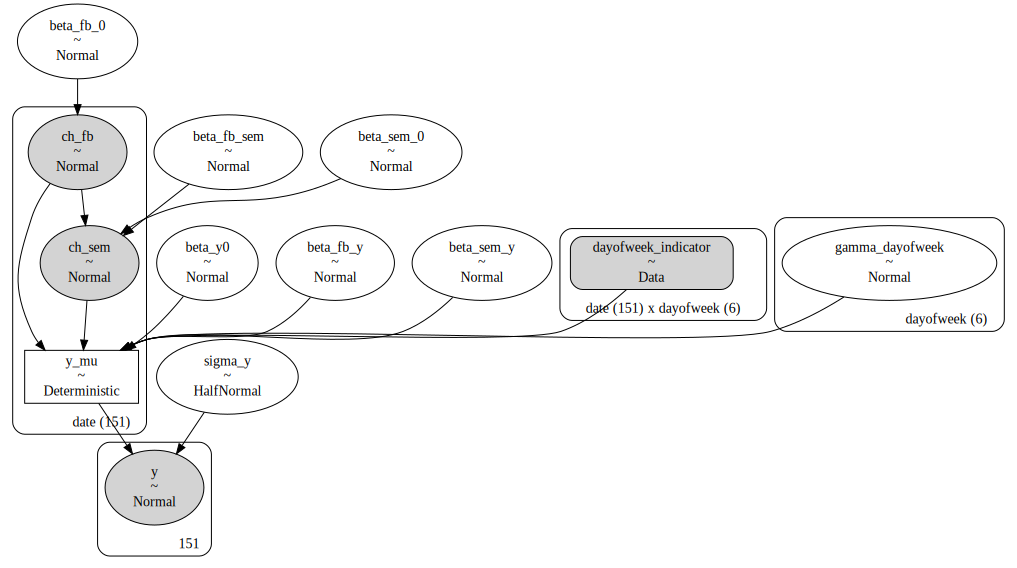

In [23]:
pm.model_to_graphviz(model=mmm.model)

In [24]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [25]:
mmm.idata.posterior

<xarray.Dataset> Size: 5MB
Dimensions:          (chain: 4, draw: 1000, dayofweek: 6, date: 151)
Coordinates:
  * chain            (chain) int64 32B 0 1 2 3
  * draw             (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * dayofweek        (dayofweek) <U11 264B 'dayofweek_0' ... 'dayofweek_5'
  * date             (date) datetime64[ns] 1kB 2024-01-01 ... 2024-05-30
Data variables:
    beta_fb_0        (chain, draw) float64 32kB 0.1316 0.09406 ... 0.2942 0.116
    beta_fb_sem      (chain, draw) float64 32kB 0.487 0.6945 ... 0.04753
    beta_fb_y        (chain, draw) float64 32kB 0.512 0.5272 ... 0.5535 0.4808
    beta_sem_0       (chain, draw) float64 32kB 0.4961 0.4992 ... 0.5799 0.5072
    beta_sem_y       (chain, draw) float64 32kB 0.6135 0.6183 ... 0.631 0.5924
    beta_y0          (chain, draw) float64 32kB 0.5589 0.5688 ... 0.5337 0.5786
    gamma_dayofweek  (chain, draw, dayofweek) float64 192kB 0.8923 ... 0.2269
    sigma_y          (chain, draw) float64 32kB 0.082 0.08182 ... 0.09237
    y_mu             (chain, draw, date) float64 5MB 2.144 1.022 ... 1.202 1.391
Attributes:
    created_at:                 2024-06-18T13:49:53.501001+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1
    sampling_time:              30.735141038894653
    tuning_steps:               1000

In [26]:
mmm.idata.posterior_predictive

<xarray.Dataset> Size: 19MB
Dimensions:  (chain: 4, draw: 1000, date: 151, y_dim_2: 151)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * date     (date) datetime64[ns] 1kB 2024-01-01 2024-01-02 ... 2024-05-30
  * y_dim_2  (y_dim_2) int64 1kB 0 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
Data variables:
    ch_fb    (chain, draw, date) float64 5MB -0.3113 1.699 ... -0.8318 -1.785
    ch_sem   (chain, draw, date) float64 5MB 2.242 1.982 2.779 ... 3.045 -0.2398
    y        (chain, draw, y_dim_2) float64 5MB 2.482 3.041 ... 2.446 0.02864
    y_mu     (chain, draw, date) float64 5MB 2.668 2.914 ... 2.273 -0.03333
Attributes:
    created_at:                 2024-06-18T13:49:56.650099+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

/tmp/ipykernel_939998/533560589.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


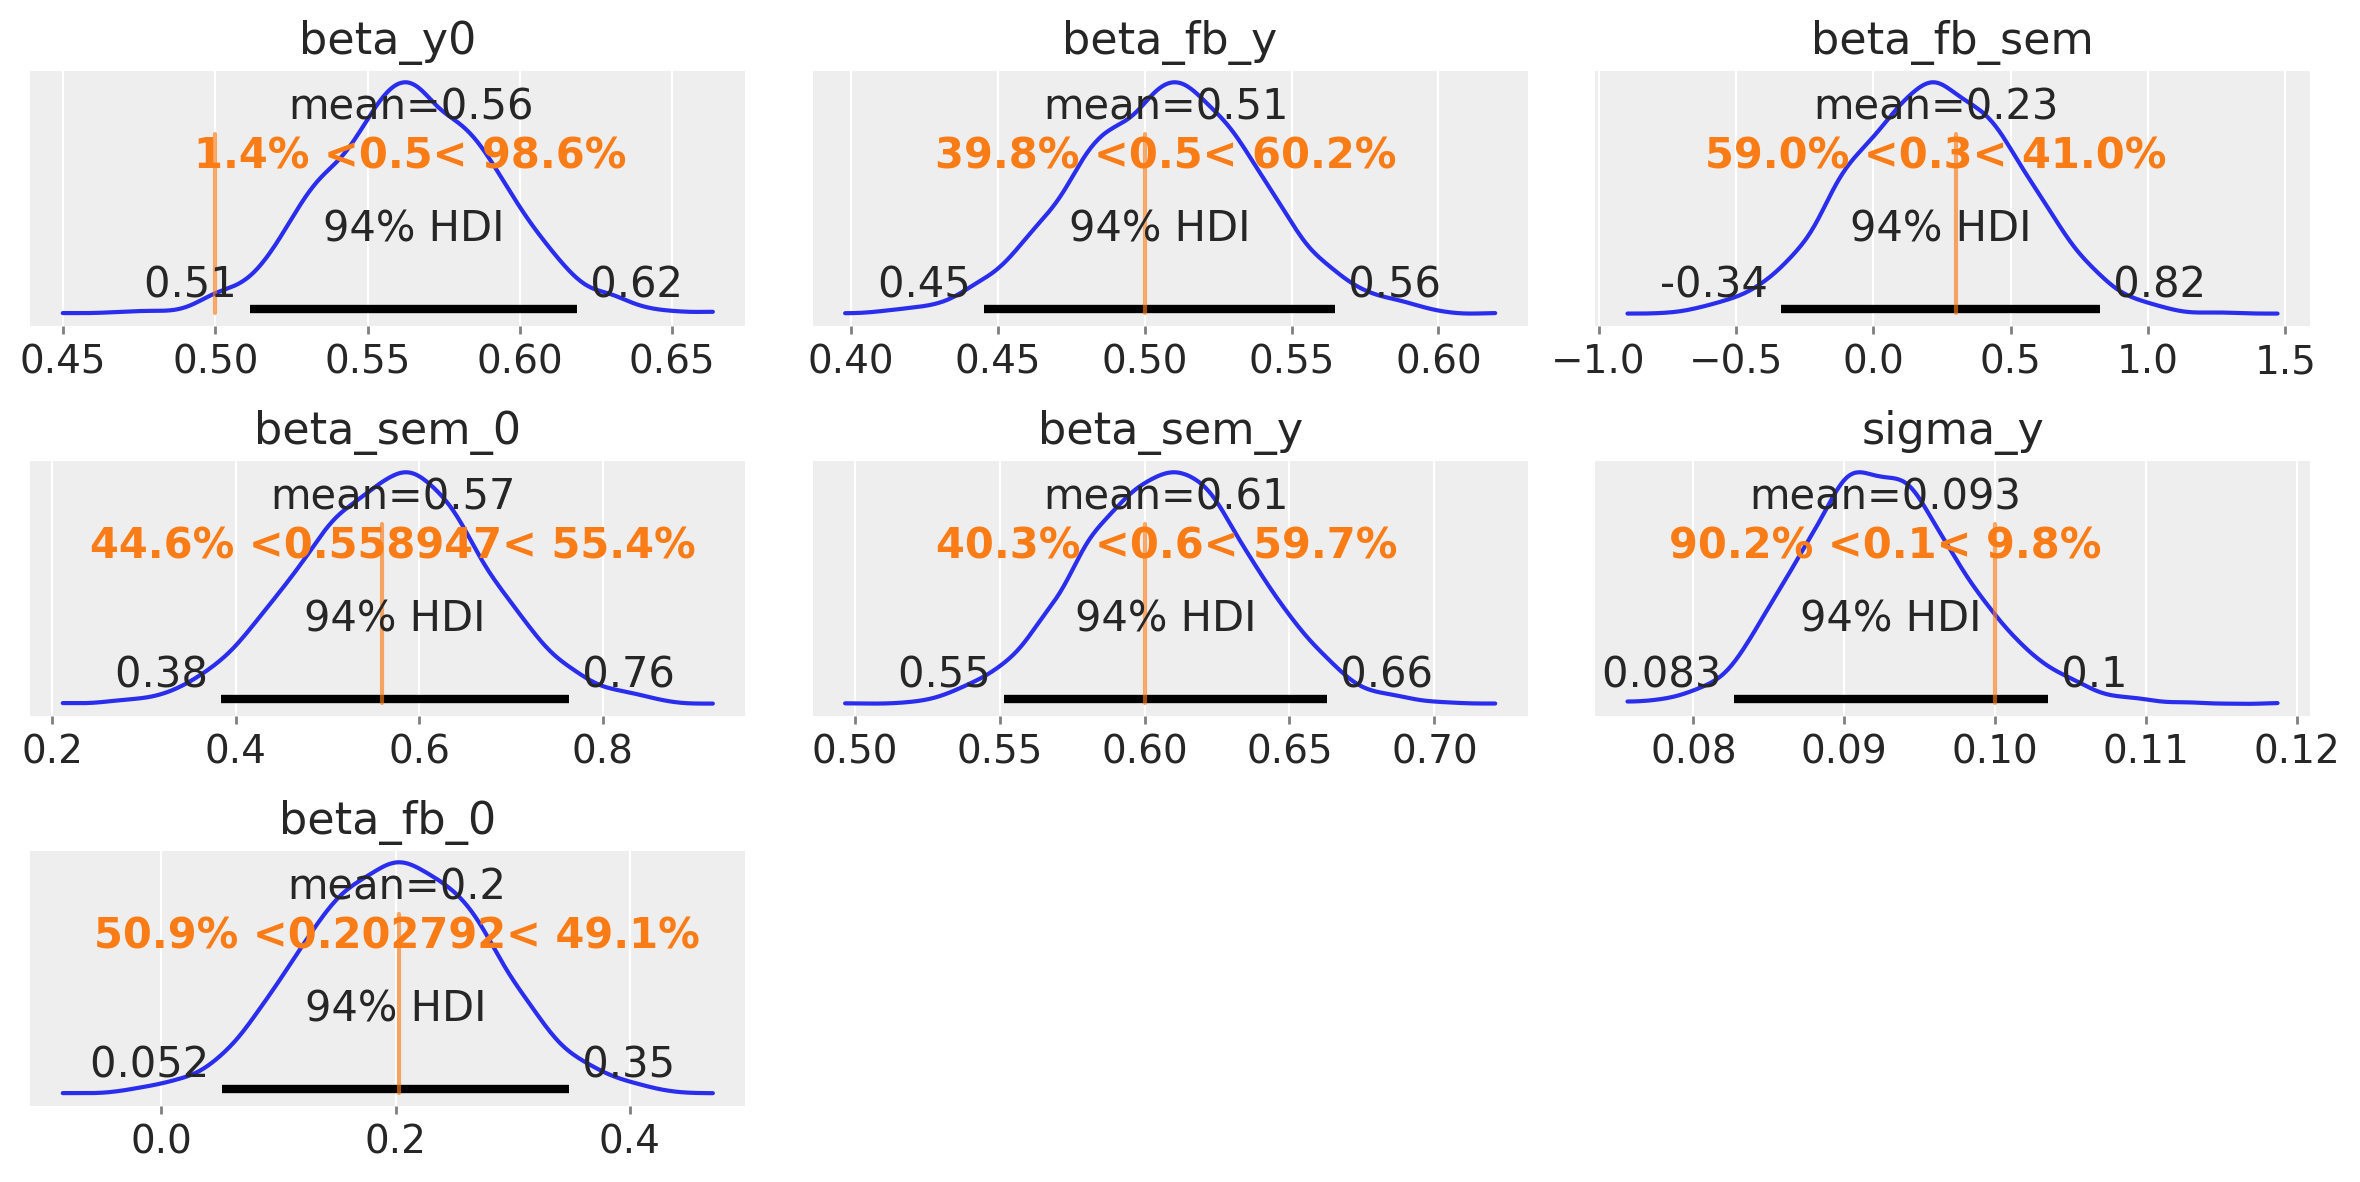

In [27]:
az.plot_posterior(
    mmm.idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(12, 6),
)
plt.tight_layout();

/tmp/ipykernel_939998/114303393.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


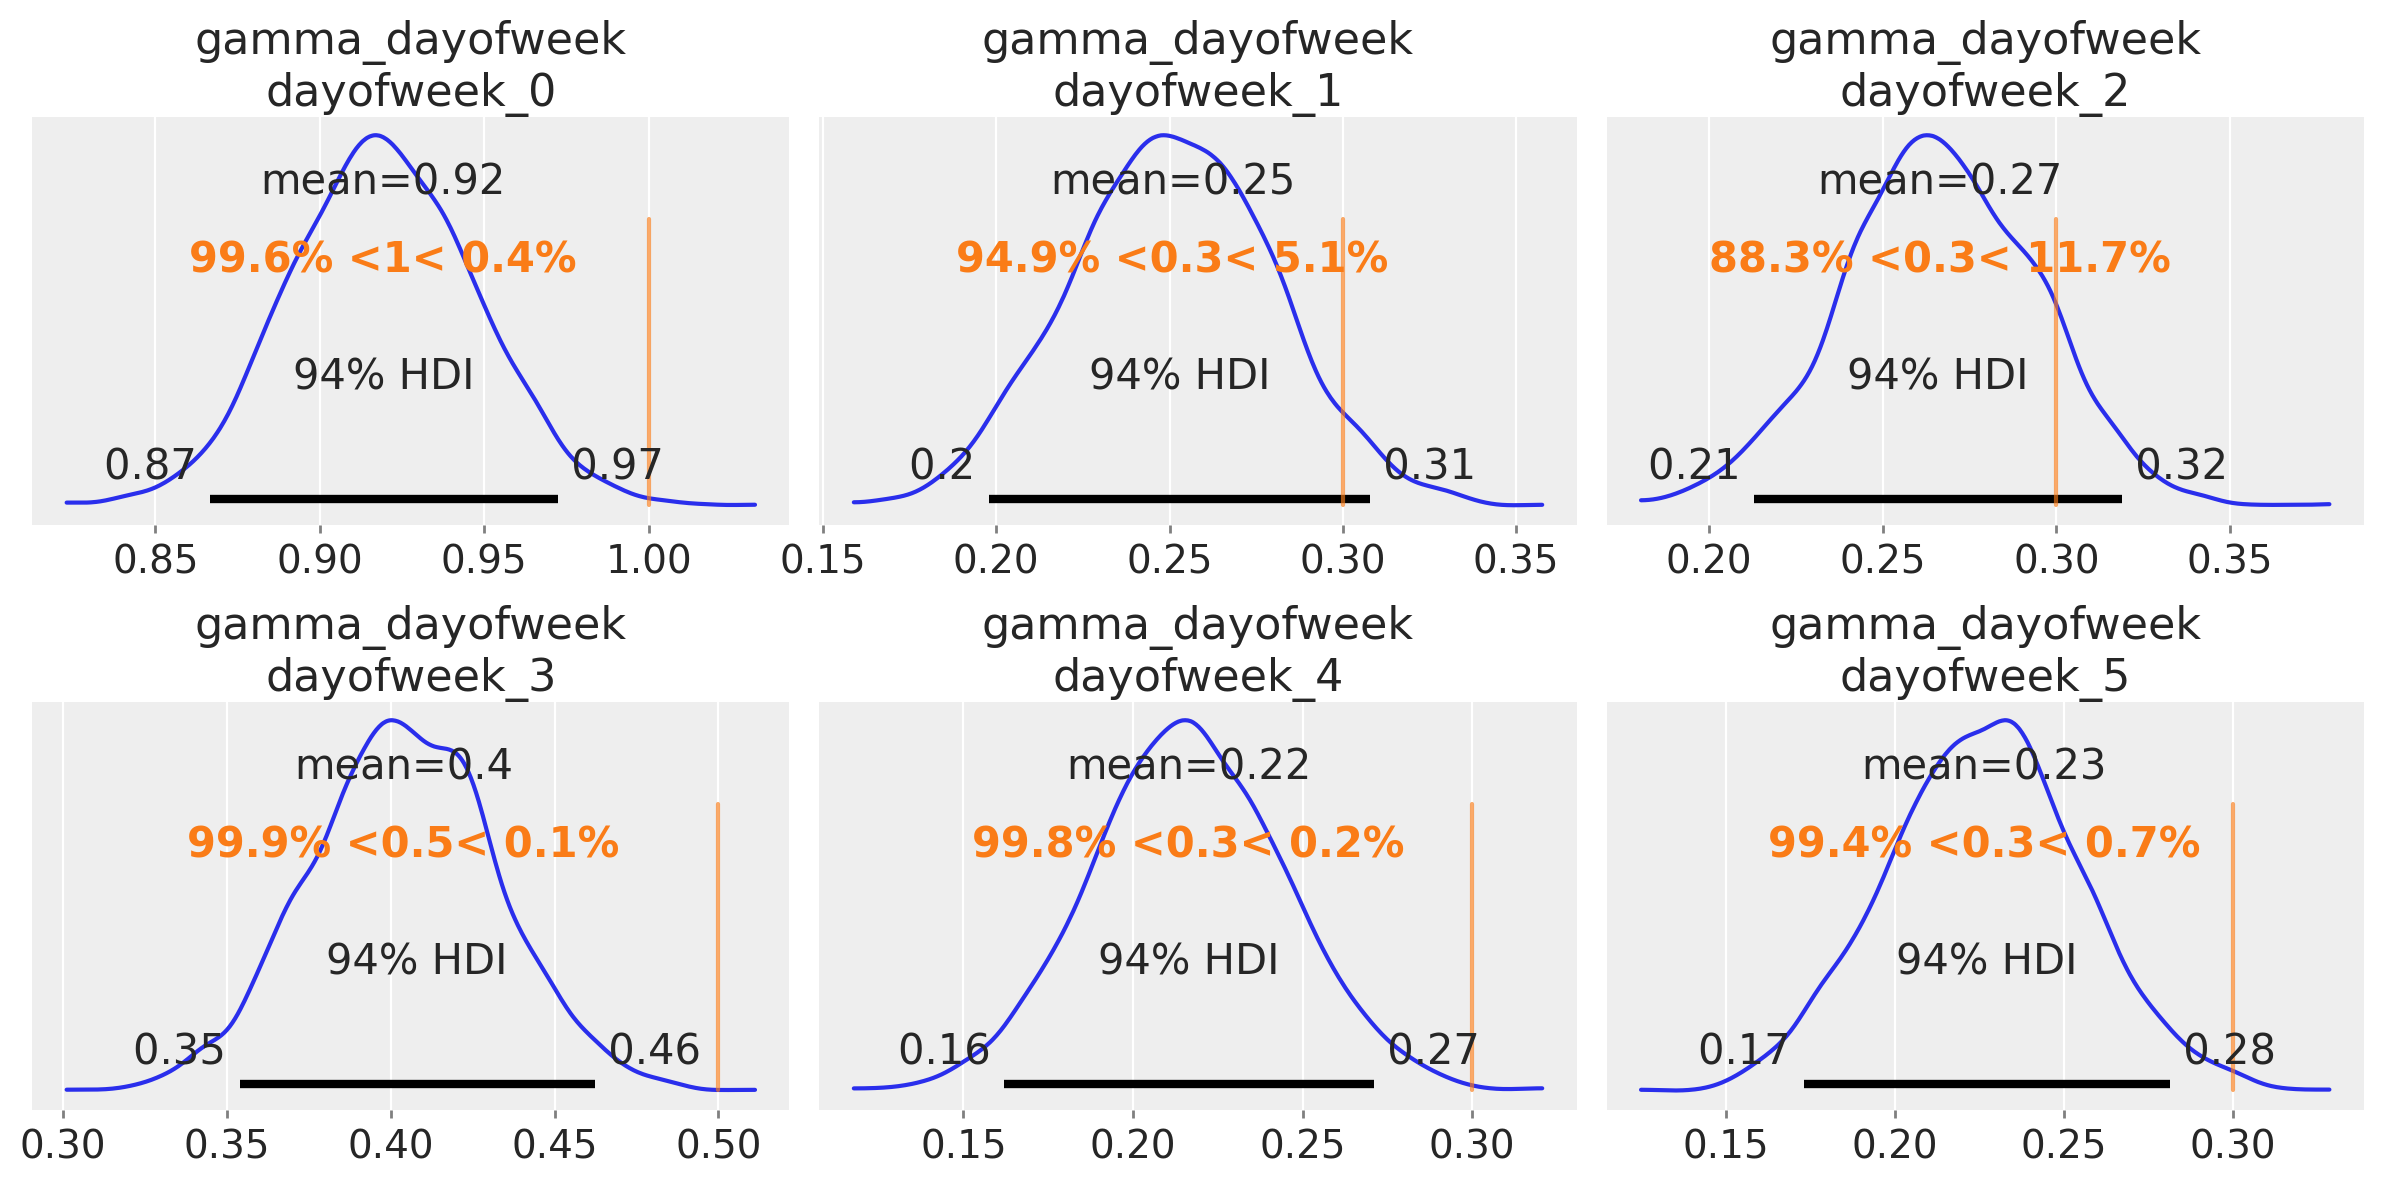

In [29]:
az.plot_posterior(
    mmm.idata,
    var_names=["gamma_dayofweek"],
    ref_val=dow_gamma_true,
    figsize=(12, 6),
)
plt.tight_layout();

In [34]:
az.summary(mmm.idata, var_names=list(true_values.keys()) + ["gamma_dayofweek"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_y0,0.564,0.029,0.511,0.619,0.001,0.001,1252.0,1816.0,1.0
beta_fb_y,0.507,0.032,0.445,0.565,0.000,0.000,4743.0,2740.0,1.0
beta_fb_sem,0.228,0.314,-0.336,0.824,0.005,0.004,3785.0,3295.0,1.0
beta_sem_0,0.571,0.101,0.384,0.763,0.002,0.001,3388.0,3331.0,1.0
beta_sem_y,0.608,0.030,0.551,0.663,0.001,0.000,2675.0,2559.0,1.0
sigma_y,0.093,0.006,0.083,0.103,0.000,0.000,4648.0,3247.0,1.0
beta_fb_0,0.201,0.079,0.052,0.348,0.001,0.001,5291.0,3302.0,1.0
gamma_dayofweek[dayofweek_0],0.919,0.029,0.867,0.972,0.001,0.000,1765.0,2235.0,1.0
gamma_dayofweek[dayofweek_1],0.251,0.029,0.198,0.308,0.001,0.001,1600.0,2485.0,1.0
gamma_dayofweek[dayofweek_2],0.266,0.028,0.213,0.319,0.001,0.000,1706.0,2286.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

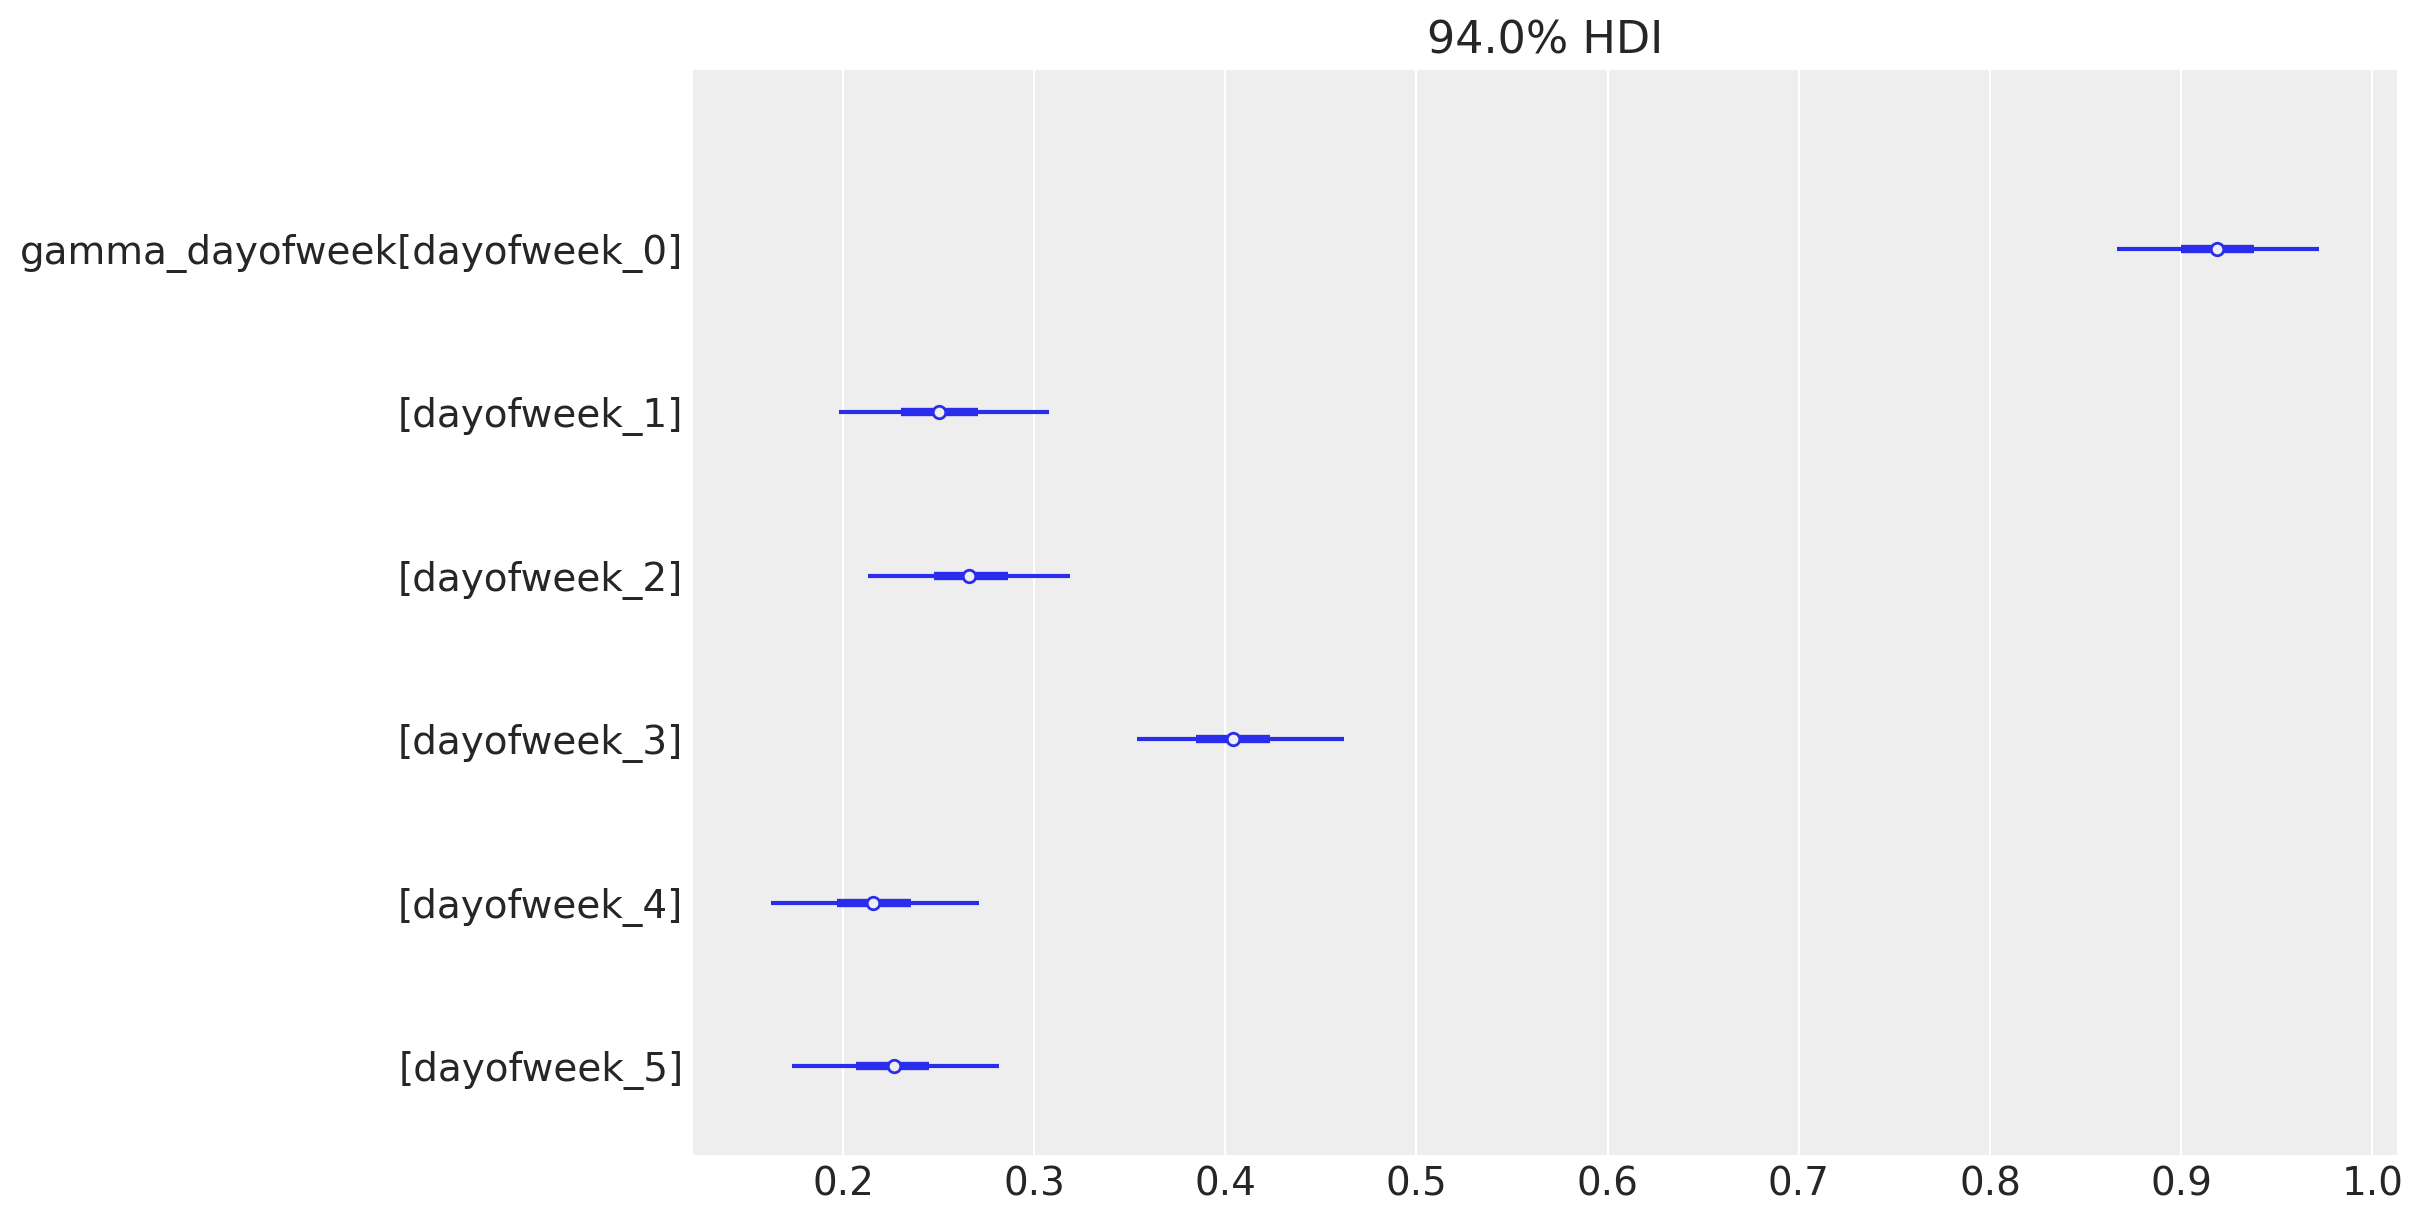

In [35]:
az.plot_forest(
    mmm.idata,
    var_names=["gamma_dayofweek"],
    combined=True,
    figsize=(12, 6),
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

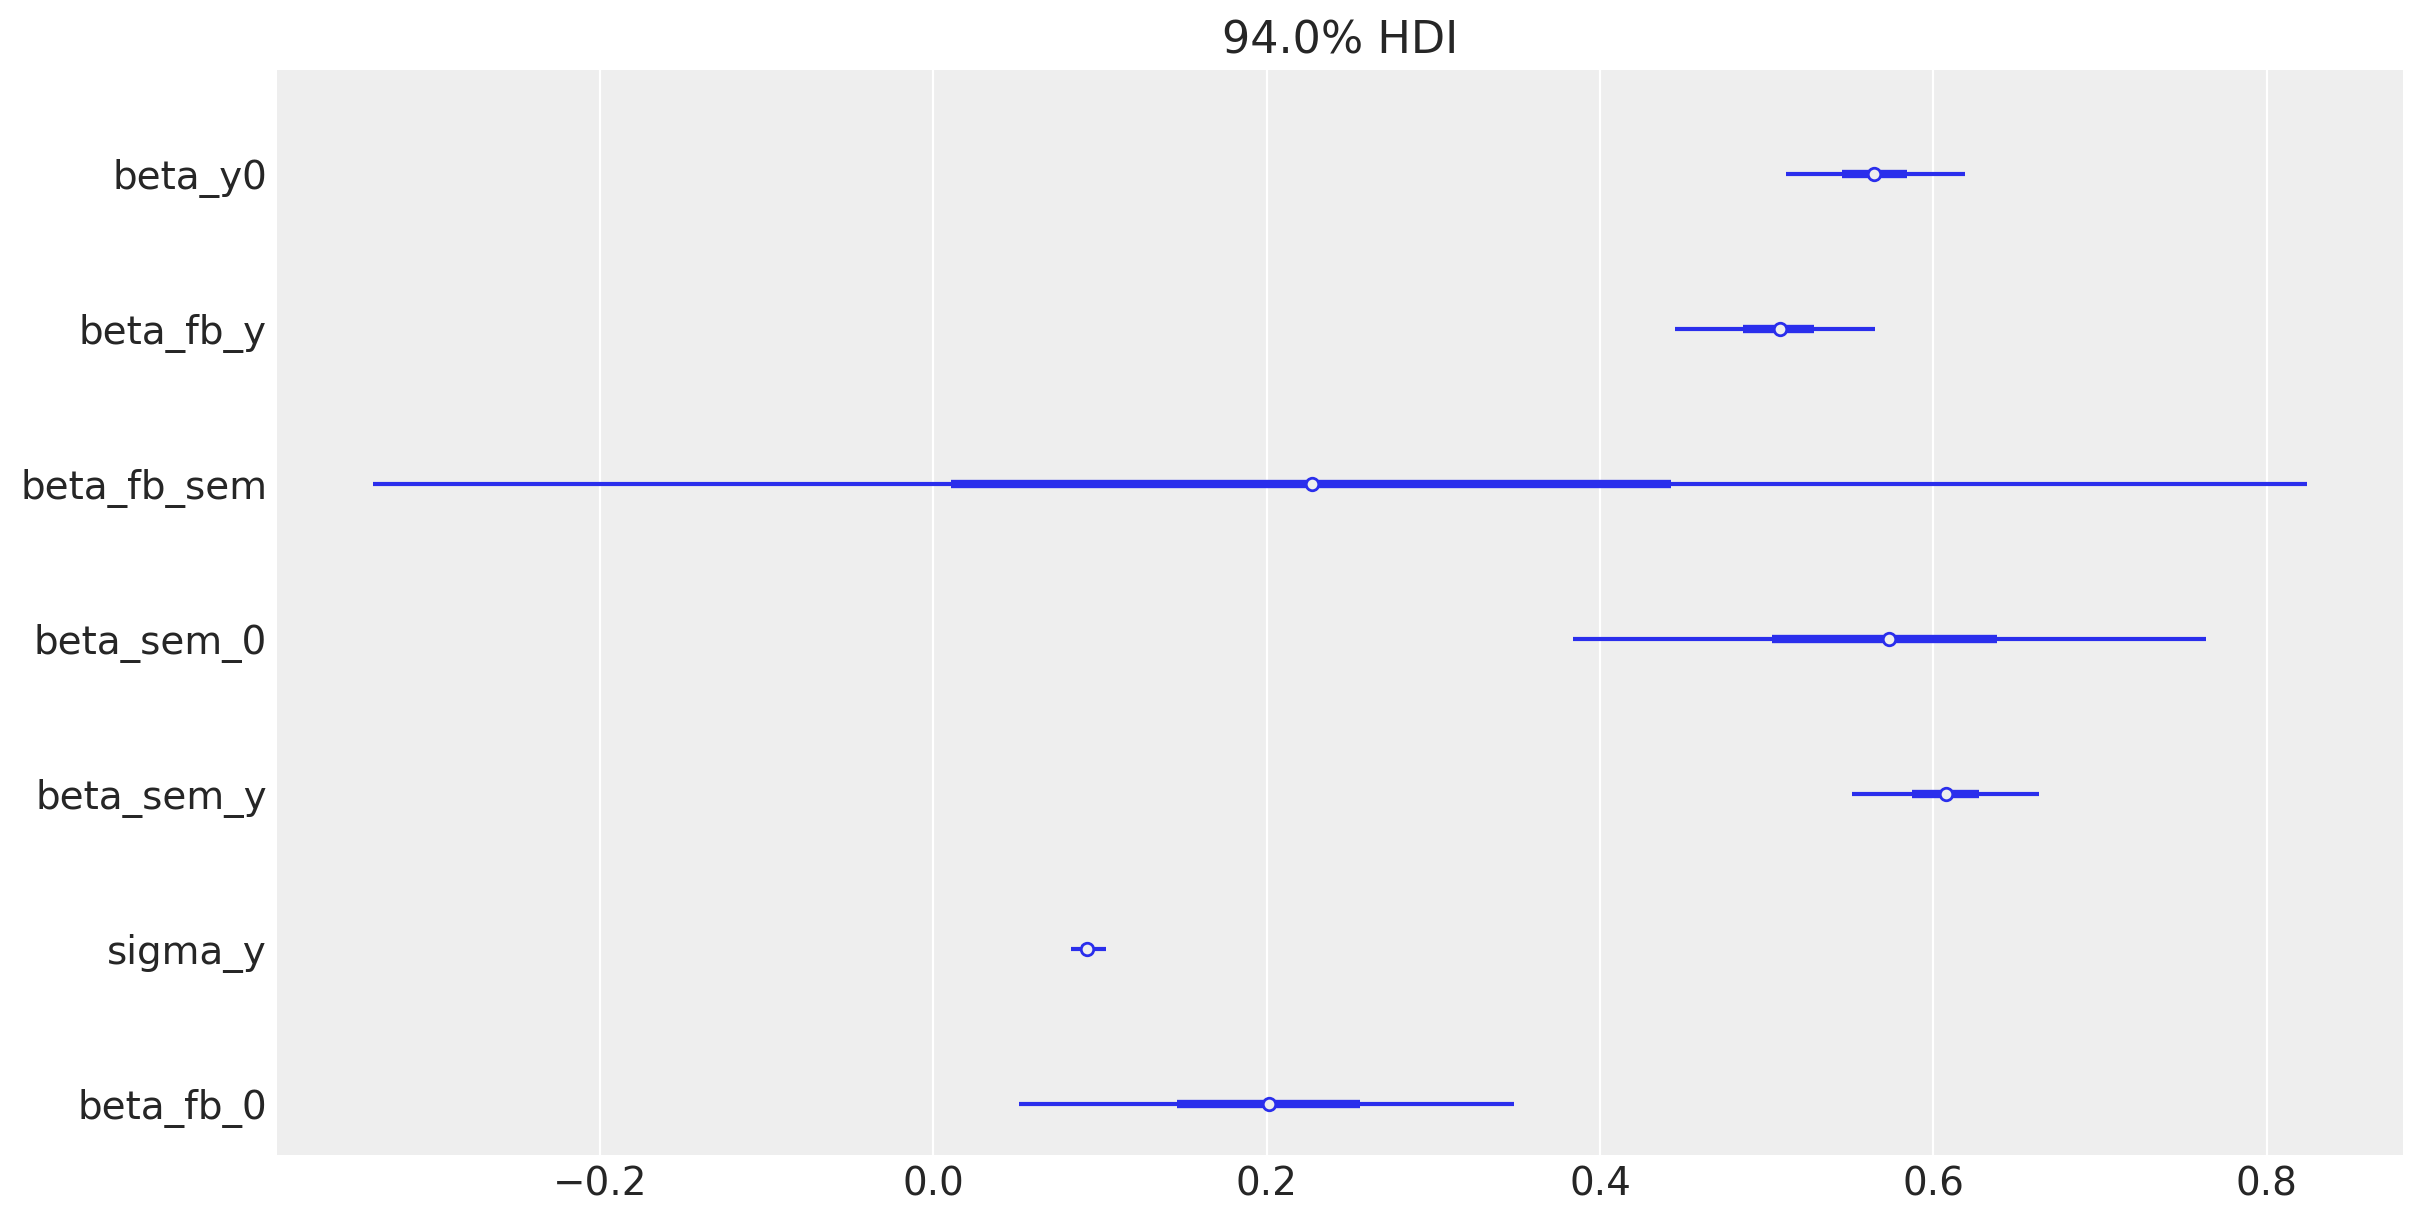

In [36]:
az.plot_forest(mmm.idata, var_names=list(true_values.keys()), combined=True, figsize=(12, 6))